
Summary of Parity & Congruence by n mod 8:

 mod8  odd_parity_pct  even_parity_pct  congruent_pct  theoretical_bound
    1             0.0              1.0       0.105918               0.50
    2             0.0              1.0       0.102179               0.50
    3             0.0              1.0       0.075503               0.50
    5             1.0              0.0       1.000000               0.75
    6             1.0              0.0       1.000000               0.75
    7             1.0              0.0       1.000000               0.75


/tmp/ipykernel_152625/857780930.py:10: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file)


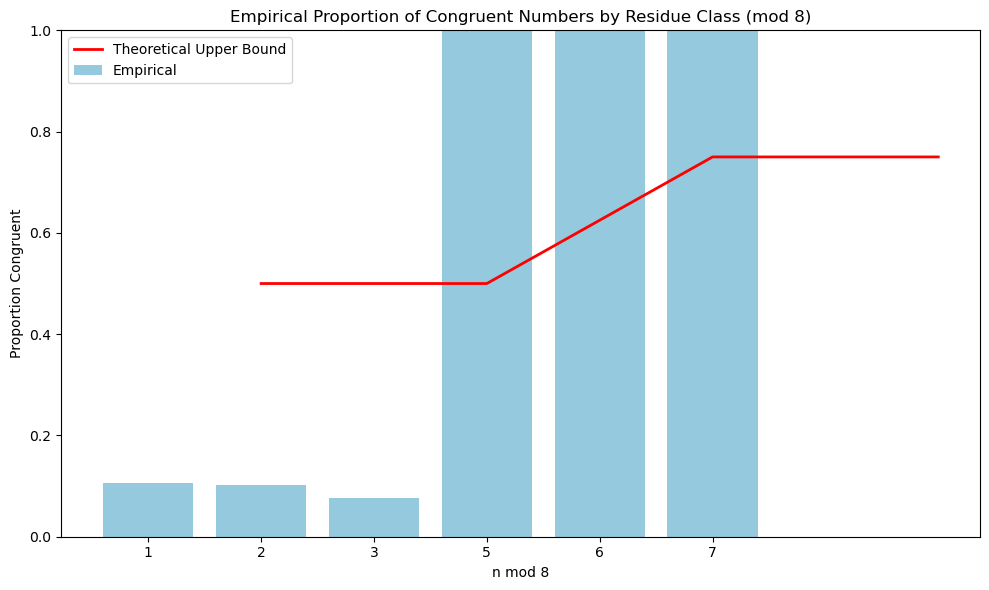

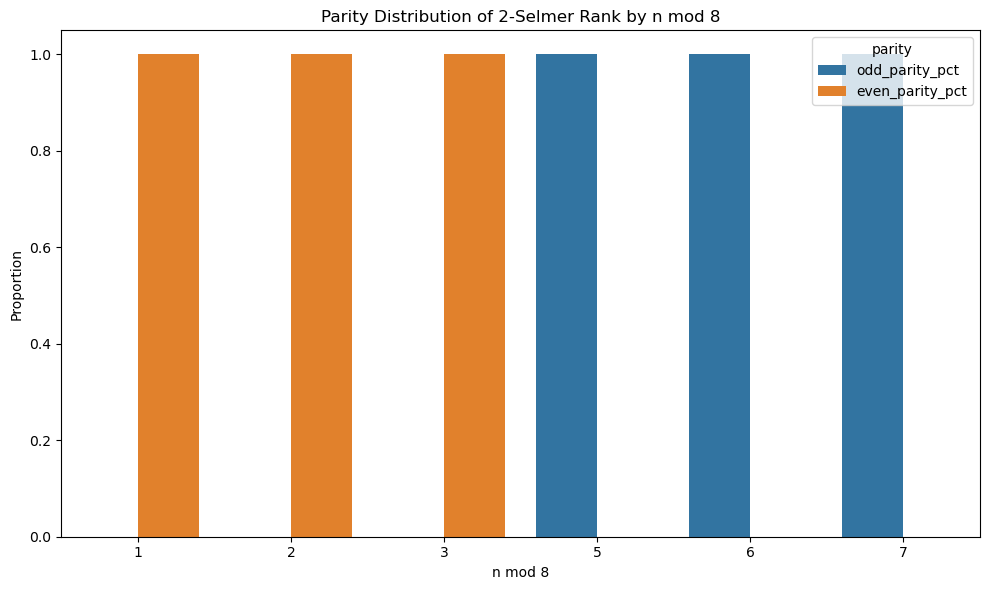

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Input CSV with 'n', 'mod8', 'selmer2_rank', 'iscongruent'
input_file = 'data_with_mod8.csv'

# Load dataset
df = pd.read_csv(input_file)

# Validate required columns
required_cols = {'n', 'mod8', '2selmer_rank', 'iscongruent'}
if not required_cols.issubset(df.columns):
    raise ValueError(f"Input file must contain: {required_cols}")

# Parity of Selmer ranks: even (0), odd (1)
df['parity'] = df['2selmer_rank'] % 2

# Empirical parity and congruence distribution by mod8
summary = []

for mod8_class in sorted(df['mod8'].unique()):
    group = df[df['mod8'] == mod8_class]
    count = len(group)

    # Parity distribution
    parity_counts = group['parity'].value_counts(normalize=True).to_dict()
    odd_pct = parity_counts.get(1, 0)
    even_pct = parity_counts.get(0, 0)

    # Congruent distribution
    congruent_pct = group['iscongruent'].mean()

    summary.append({
        'mod8': mod8_class,
        'odd_parity_pct': odd_pct,
        'even_parity_pct': even_pct,
        'congruent_pct': congruent_pct
    })

summary_df = pd.DataFrame(summary)

# Add theoretical upper bounds (based on Heath-Brown expectations)
def get_upper_bound(mod8):
    if mod8 in {5, 6, 7}:
        return 0.75
    elif mod8 in {1, 2, 3}:
        return 0.50
    elif mod8 == 4:
        return 0.0
    else:
        return 0.1  # heuristic bound for mod 0

summary_df['theoretical_bound'] = summary_df['mod8'].apply(get_upper_bound)

# Print summary table
print("\nSummary of Parity & Congruence by n mod 8:\n")
print(summary_df.to_string(index=False))

# Plot: Congruent % with Theoretical Bound
plt.figure(figsize=(10, 6))
sns.barplot(data=summary_df, x='mod8', y='congruent_pct', color='skyblue', label='Empirical')
sns.lineplot(data=summary_df, x='mod8', y='theoretical_bound', color='red', linewidth=2, label='Theoretical Upper Bound')
plt.title("Empirical Proportion of Congruent Numbers by Residue Class (mod 8)")
plt.ylabel("Proportion Congruent")
plt.xlabel("n mod 8")
plt.legend()
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

# Plot: Selmer Parity by mod 8
plt.figure(figsize=(10, 6))
parity_plot = summary_df.melt(id_vars='mod8', value_vars=['odd_parity_pct', 'even_parity_pct'],
                              var_name='parity', value_name='percentage')
sns.barplot(data=parity_plot, x='mod8', y='percentage', hue='parity')
plt.title("Parity Distribution of 2-Selmer Rank by n mod 8")
plt.ylabel("Proportion")
plt.xlabel("n mod 8")
plt.tight_layout()
plt.show()


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

# Input and output files
input_file = 'data_with_mod8.csv'
summary_csv = 'selmer_summary_by_mod8.csv'
output_pdf = 'selmer_congruence_analysis.pdf'

# Load dataset
df = pd.read_csv(input_file)

# Ensure required columns
required_cols = {'n', 'mod8', '2selmer_rank', 'iscongruent'}
if not required_cols.issubset(df.columns):
    raise ValueError(f"Input file must contain columns: {required_cols}")

# Add parity column
df['parity'] = df['2selmer_rank'] % 2

# Define theoretical congruent bounds based on mod 8
def get_upper_bound(mod8):
    if mod8 in {5, 6, 7}:
        return 0.75
    elif mod8 in {1, 2, 3}:
        return 0.50
    elif mod8 == 4:
        return 0.0
    else:
        return 0.1  # conservative bound for mod8 = 0

# Build summary with actual counts and percentages
summary_data = []

for mod8_class in sorted(df['mod8'].unique()):
    group = df[df['mod8'] == mod8_class]
    total = len(group)
    congruent_count = group['iscongruent'].sum()
    odd_count = (group['parity'] == 1).sum()
    even_count = (group['parity'] == 0).sum()

    summary_data.append({
        'mod8': mod8_class,
        'total': total,
        'congruent_count': congruent_count,
        'congruent_pct': congruent_count / total if total > 0 else 0,
        'odd_count': odd_count,
        'odd_pct': odd_count / total if total > 0 else 0,
        'even_count': even_count,
        'even_pct': even_count / total if total > 0 else 0,
        'theoretical_bound': get_upper_bound(mod8_class)
    })

summary_df = pd.DataFrame(summary_data)

# Save summary to CSV
summary_df.to_csv(summary_csv, index=False)
print(f"Summary table saved to {summary_csv}")

# Begin PDF output
with PdfPages(output_pdf) as pdf:
    # Plot 1: Congruent proportion vs theoretical bound
    plt.figure(figsize=(10, 6))
    sns.barplot(data=summary_df, x='mod8', y='congruent_pct', color='skyblue', label='Empirical')
    sns.lineplot(data=summary_df, x='mod8', y='theoretical_bound', color='red', label='Theoretical Bound', linewidth=2)
    plt.title("Empirical vs Theoretical Proportion of Congruent Numbers (by n mod 8)")
    plt.ylabel("Proportion Congruent")
    plt.xlabel("n mod 8")
    plt.ylim(0, 1.0)
    plt.legend()
    plt.tight_layout()
    pdf.savefig()
    plt.close()

    # Plot 2: Selmer parity distribution (stacked bar chart)
    parity_df = summary_df.melt(
        id_vars='mod8',
        value_vars=['odd_pct', 'even_pct'],
        var_name='parity',
        value_name='proportion'
    )
    plt.figure(figsize=(10, 6))
    sns.barplot(data=parity_df, x='mod8', y='proportion', hue='parity')
    plt.title("Parity Distribution of 2-Selmer Rank by n mod 8")
    plt.ylabel("Proportion")
    plt.xlabel("n mod 8")
    plt.ylim(0, 1.0)
    plt.tight_layout()
    pdf.savefig()
    plt.close()

print(f"Plots saved to {output_pdf}")


/tmp/ipykernel_152625/3687224013.py:12: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file)


Summary table saved to selmer_summary_by_mod8.csv
Plots saved to selmer_congruence_analysis.pdf


In [8]:
import plotly.express as px

# Count selmer ranks per mod8 class
hist_df = df.groupby(['mod8', '2selmer_rank']).size().reset_index(name='count')

# Normalize per mod8 class
hist_df['total'] = hist_df.groupby('mod8')['count'].transform('sum')
hist_df['percentage'] = hist_df['count'] / hist_df['total']

# Save CSV of full histogram if needed
hist_df.to_csv('selmer_rank_histogram_by_mod8.csv', index=False)


Dashboard creation